# 房價預測 - 建模與預測
## Kaggle Competition: House Prices - Advanced Regression Techniques

本 Notebook 包含：
1. 載入預處理後的數據
2. Baseline 模型
3. 線性模型 (Ridge, Lasso, ElasticNet)
4. 樹模型 (XGBoost, LightGBM, CatBoost)
5. 模型調優
6. 模型融合 (Stacking)
7. 生成提交文件

In [1]:
# 導入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 設定顯示選項
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']


## 1. 載入預處理後的數據

In [2]:
# 載入數據
X_train = pd.read_csv('X_train_processed.csv')
X_test = pd.read_csv('X_test_processed.csv')
y_train_log = pd.read_csv('y_train_log.csv')['SalePrice_log']

# 載入標準化版本（線性模型用）
X_train_scaled = pd.read_csv('X_train_scaled.csv')
X_test_scaled = pd.read_csv('X_test_scaled.csv')

# 載入 ID
test_ID = pd.read_csv('test_ids.csv')['Id']

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"目標變數大小: {y_train_log.shape}")
print(f"特徵數量: {X_train.shape[1]}")

訓練集大小: (1458, 233)
測試集大小: (1459, 233)
目標變數大小: (1458,)
特徵數量: 233


## 2. 定義評估函數

使用 RMSE (Root Mean Squared Error) 作為主要評估指標，這也是 Kaggle 競賽使用的指標。

In [ ]:
def rmse_cv(model, X, y, cv=5):
    """
    使用交叉驗證計算 RMSE
    注意：sklearn 的 cross_val_score 返回負的 MSE，需要轉換
    """
    kfold = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                     scoring="neg_mean_squared_error", 
                                     cv=kfold))
    return rmse

def rmsle(y_true, y_pred):
    """
    計算 RMSLE (Root Mean Squared Logarithmic Error)
    這是 Kaggle 競賽的評估指標
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X, y, model_name, cv=5):
    """
    評估模型性能
    """
    scores = rmse_cv(model, X, y, cv=cv)
    print(f"\n{model_name}:")
    print(f"  RMSE: {scores.mean():.6f} (+/- {scores.std():.6f})")
    return scores.mean(), scores.std()

print("評估函數定義完成！")

評估函數定義完成！


## 3. Baseline 模型 - 簡單平均

先建立一個最簡單的 baseline，預測所有房屋的價格為訓練集的平均值。

In [4]:
# Baseline: 預測平均值
baseline_pred = np.full(len(y_train_log), y_train_log.mean())
baseline_rmse = rmsle(y_train_log, baseline_pred)

print(f"Baseline RMSE (預測平均值): {baseline_rmse:.6f}")
print(f"這是我們需要超越的基準！")

Baseline RMSE (預測平均值): 0.399576
這是我們需要超越的基準！


## 4. 線性模型

### 4.1 Ridge Regression (L2 正則化)

In [5]:
# Ridge Regression
ridge = Ridge(alpha=10, random_state=RANDOM_SEED)
ridge_scores = evaluate_model(ridge, X_train_scaled, y_train_log, "Ridge Regression")

# 訓練完整模型
ridge.fit(X_train_scaled, y_train_log)
ridge_train_pred = ridge.predict(X_train_scaled)
print(f"訓練集 RMSE: {rmsle(y_train_log, ridge_train_pred):.6f}")


Ridge Regression:
  RMSE: 0.121708 (+/- 0.010959)
訓練集 RMSE: 0.093118


### 4.2 Lasso Regression (L1 正則化)

In [6]:
# Lasso Regression
lasso = Lasso(alpha=0.0005, max_iter=10000, random_state=RANDOM_SEED)
lasso_scores = evaluate_model(lasso, X_train_scaled, y_train_log, "Lasso Regression")

# 訓練完整模型
lasso.fit(X_train_scaled, y_train_log)
lasso_train_pred = lasso.predict(X_train_scaled)
print(f"訓練集 RMSE: {rmsle(y_train_log, lasso_train_pred):.6f}")

# 查看 Lasso 選擇的特徵數量
lasso_coef = pd.Series(lasso.coef_, index=X_train_scaled.columns)
print(f"\nLasso 選擇了 {(lasso_coef != 0).sum()} 個特徵（非零係數）")


Lasso Regression:
  RMSE: 0.118886 (+/- 0.009262)
訓練集 RMSE: 0.093919

Lasso 選擇了 178 個特徵（非零係數）


### 4.3 ElasticNet (L1 + L2 正則化)

In [7]:
# ElasticNet
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_SEED)
elasticnet_scores = evaluate_model(elasticnet, X_train_scaled, y_train_log, "ElasticNet")

# 訓練完整模型
elasticnet.fit(X_train_scaled, y_train_log)
elasticnet_train_pred = elasticnet.predict(X_train_scaled)
print(f"訓練集 RMSE: {rmsle(y_train_log, elasticnet_train_pred):.6f}")


ElasticNet:
  RMSE: 0.121167 (+/- 0.010024)
訓練集 RMSE: 0.093436


## 5. 樹模型

### 5.1 Gradient Boosting

In [8]:
# Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=RANDOM_SEED
)

gbr_scores = evaluate_model(gbr, X_train, y_train_log, "Gradient Boosting")

# 訓練完整模型
gbr.fit(X_train, y_train_log)
gbr_train_pred = gbr.predict(X_train)
print(f"訓練集 RMSE: {rmsle(y_train_log, gbr_train_pred):.6f}")


Gradient Boosting:
  RMSE: 0.115368 (+/- 0.010591)
訓練集 RMSE: 0.048654


### 5.2 XGBoost

In [9]:
# XGBoost
xgboost = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:squarederror',
    random_state=RANDOM_SEED
)

xgboost_scores = evaluate_model(xgboost, X_train, y_train_log, "XGBoost")

# 訓練完整模型
xgboost.fit(X_train, y_train_log)
xgboost_train_pred = xgboost.predict(X_train)
print(f"訓練集 RMSE: {rmsle(y_train_log, xgboost_train_pred):.6f}")


XGBoost:
  RMSE: 0.115793 (+/- 0.005543)
訓練集 RMSE: 0.002484


### 5.3 LightGBM

In [10]:
# LightGBM
lightgbm = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=RANDOM_SEED,
    verbosity=-1
)

lightgbm_scores = evaluate_model(lightgbm, X_train, y_train_log, "LightGBM")

# 訓練完整模型
lightgbm.fit(X_train, y_train_log)
lightgbm_train_pred = lightgbm.predict(X_train)
print(f"訓練集 RMSE: {rmsle(y_train_log, lightgbm_train_pred):.6f}")


LightGBM:
  RMSE: 0.123206 (+/- 0.006381)
訓練集 RMSE: 0.012065


### 5.4 CatBoost

In [11]:
# CatBoost
catboost = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=10,
    loss_function='RMSE',
    random_state=RANDOM_SEED,
    verbose=False
)

catboost_scores = evaluate_model(catboost, X_train, y_train_log, "CatBoost")

# 訓練完整模型
catboost.fit(X_train, y_train_log)
catboost_train_pred = catboost.predict(X_train)
print(f"訓練集 RMSE: {rmsle(y_train_log, catboost_train_pred):.6f}")


CatBoost:
  RMSE: 0.112905 (+/- 0.006822)
訓練集 RMSE: 0.034643


## 6. 模型性能比較

In [12]:
# 整理所有模型的結果
model_results = pd.DataFrame({
    'Model': ['Baseline', 'Ridge', 'Lasso', 'ElasticNet', 'GradientBoost', 'XGBoost', 'LightGBM', 'CatBoost'],
    'CV_RMSE_Mean': [
        baseline_rmse,
        ridge_scores[0],
        lasso_scores[0],
        elasticnet_scores[0],
        gbr_scores[0],
        xgboost_scores[0],
        lightgbm_scores[0],
        catboost_scores[0]
    ],
    'CV_RMSE_Std': [
        0,
        ridge_scores[1],
        lasso_scores[1],
        elasticnet_scores[1],
        gbr_scores[1],
        xgboost_scores[1],
        lightgbm_scores[1],
        catboost_scores[1]
    ]
})

model_results = model_results.sort_values('CV_RMSE_Mean')
print("\n模型性能排名:")
print(model_results.to_string(index=False))


模型性能排名:
        Model  CV_RMSE_Mean  CV_RMSE_Std
     CatBoost      0.112905     0.006822
GradientBoost      0.115368     0.010591
      XGBoost      0.115793     0.005543
        Lasso      0.118886     0.009262
   ElasticNet      0.121167     0.010024
        Ridge      0.121708     0.010959
     LightGBM      0.123206     0.006381
     Baseline      0.399576     0.000000


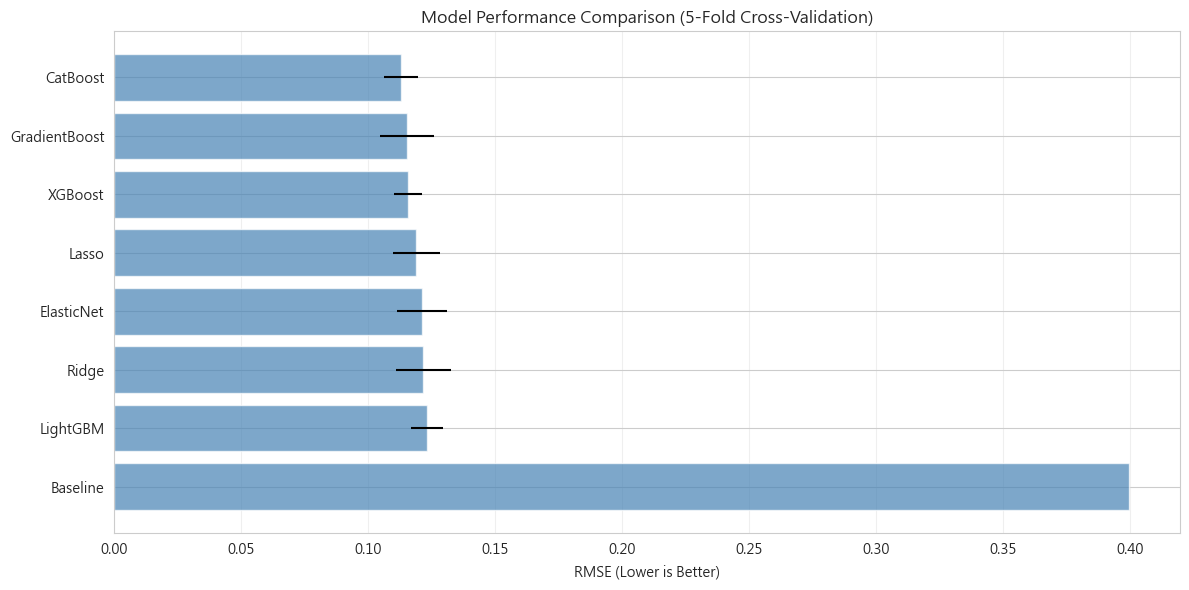


最佳單一模型: CatBoost
RMSE: 0.112905


In [13]:
# 視覺化模型比較
plt.figure(figsize=(12, 6))
plt.barh(model_results['Model'], model_results['CV_RMSE_Mean'], 
         xerr=model_results['CV_RMSE_Std'], color='steelblue', alpha=0.7)
plt.xlabel('RMSE (Lower is Better)')
plt.title('Model Performance Comparison (5-Fold Cross-Validation)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n最佳單一模型: {model_results.iloc[0]['Model']}")
print(f"RMSE: {model_results.iloc[0]['CV_RMSE_Mean']:.6f}")

## 7. 特徵重要性分析

In [14]:
# XGBoost 特徵重要性
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgboost.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 最重要的特徵 (XGBoost):")
print(feature_importance.head(20).to_string(index=False))

Top 20 最重要的特徵 (XGBoost):
             Feature  Importance
         OverallQual    0.198632
             TotalSF    0.079410
           ExterQual    0.067619
          CentralAir    0.066455
          GarageCars    0.043622
         KitchenQual    0.039970
         MSZoning_RM    0.039781
          GarageCond    0.031379
           TotalBath    0.027329
    MSZoning_C (all)    0.021459
        KitchenAbvGr    0.019678
Neighborhood_OldTown    0.015276
Neighborhood_Crawfor    0.015091
         OverallCond    0.013367
         FireplaceQu    0.010725
            BsmtQual    0.010507
   Condition1_Artery    0.009991
              PoolQC    0.008972
       BldgType_1Fam    0.008630
          GarageQual    0.008464


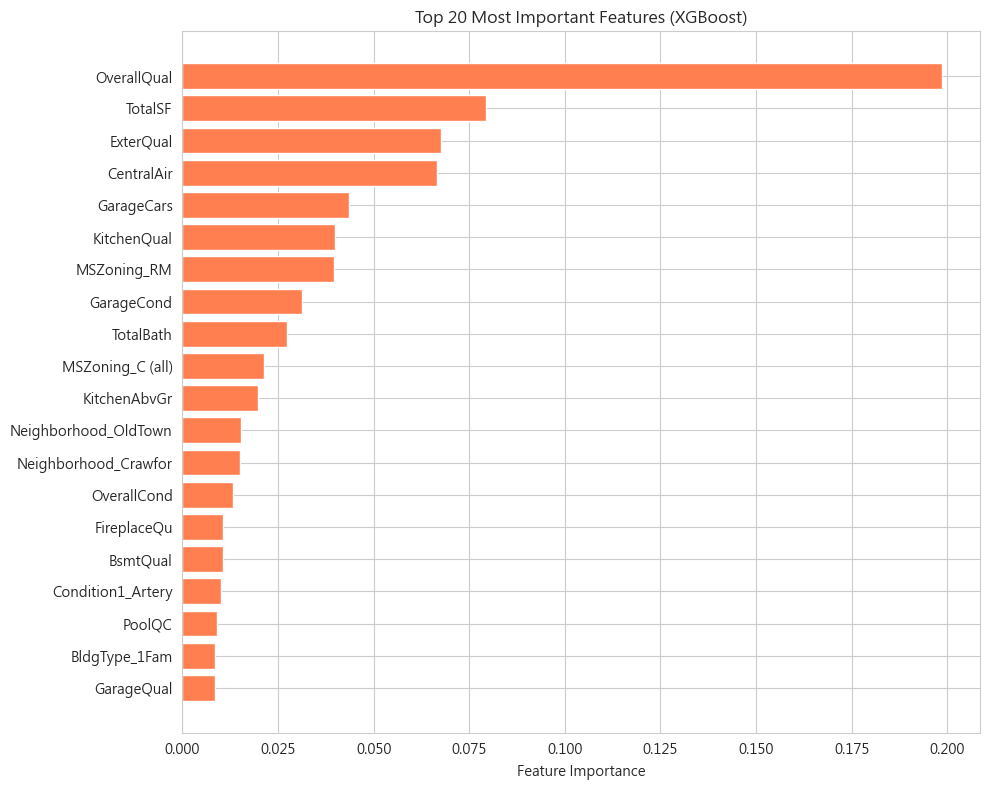

In [15]:
# 視覺化 Top 20 特徵重要性
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'].values, color='coral')
plt.yticks(range(len(top_20)), top_20['Feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. 模型融合 - Stacking

使用多個模型的預測結果進行加權平均或訓練 meta-model。

In [16]:
# 8.1 簡單平均融合
def average_models(models, X_train, y_train, X_test, weights=None):
    """
    使用加權平均融合多個模型
    """
    if weights is None:
        weights = [1/len(models)] * len(models)
    
    # 訓練所有模型並獲取預測
    train_preds = np.zeros(len(X_train))
    test_preds = np.zeros(len(X_test))
    
    for i, (model, weight) in enumerate(zip(models, weights)):
        print(f"訓練模型 {i+1}/{len(models)}...")
        model.fit(X_train, y_train)
        train_preds += weight * model.predict(X_train)
        test_preds += weight * model.predict(X_test)
    
    return train_preds, test_preds

print("模型融合函數定義完成！")

模型融合函數定義完成！


In [17]:
# 8.2 選擇要融合的模型
# 使用表現最好的幾個模型

ensemble_models = [
    ('Ridge', ridge, X_train_scaled, X_test_scaled, 0.1),
    ('Lasso', lasso, X_train_scaled, X_test_scaled, 0.1),
    ('ElasticNet', elasticnet, X_train_scaled, X_test_scaled, 0.1),
    ('XGBoost', xgboost, X_train, X_test, 0.25),
    ('LightGBM', lightgbm, X_train, X_test, 0.25),
    ('CatBoost', catboost, X_train, X_test, 0.2)
]

# 計算加權平均預測
ensemble_train_pred = np.zeros(len(X_train))
ensemble_test_pred = np.zeros(len(X_test))

for name, model, X_tr, X_te, weight in ensemble_models:
    print(f"\n使用 {name} (權重: {weight})...")
    model.fit(X_tr, y_train_log)
    ensemble_train_pred += weight * model.predict(X_tr)
    ensemble_test_pred += weight * model.predict(X_te)

# 評估融合模型
ensemble_rmse = rmsle(y_train_log, ensemble_train_pred)
print(f"\n融合模型訓練集 RMSE: {ensemble_rmse:.6f}")


使用 Ridge (權重: 0.1)...

使用 Lasso (權重: 0.1)...

使用 ElasticNet (權重: 0.1)...

使用 XGBoost (權重: 0.25)...

使用 LightGBM (權重: 0.25)...

使用 CatBoost (權重: 0.2)...

融合模型訓練集 RMSE: 0.035785


## 9. 交叉驗證融合模型

In [18]:
# 使用 KFold 交叉驗證評估融合模型
from sklearn.model_selection import KFold

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)

ensemble_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    print(f"\nFold {fold}/{n_folds}...")
    
    # 分割數據
    X_tr = X_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_tr = y_train_log.iloc[train_idx]
    y_val = y_train_log.iloc[val_idx]
    
    X_tr_scaled = X_train_scaled.iloc[train_idx]
    X_val_scaled = X_train_scaled.iloc[val_idx]
    
    # 融合預測
    fold_pred = np.zeros(len(X_val))
    
    for name, model, _, _, weight in ensemble_models:
        # 根據模型類型選擇數據
        if name in ['Ridge', 'Lasso', 'ElasticNet']:
            X_tr_use = X_tr_scaled
            X_val_use = X_val_scaled
        else:
            X_tr_use = X_tr
            X_val_use = X_val
        
        # 訓練並預測
        model.fit(X_tr_use, y_tr)
        fold_pred += weight * model.predict(X_val_use)
    
    # 計算 RMSE
    fold_rmse = rmsle(y_val, fold_pred)
    ensemble_cv_scores.append(fold_rmse)
    print(f"Fold {fold} RMSE: {fold_rmse:.6f}")

print(f"\n融合模型 CV RMSE: {np.mean(ensemble_cv_scores):.6f} (+/- {np.std(ensemble_cv_scores):.6f})")


Fold 1/5...
Fold 1 RMSE: 0.111147

Fold 2/5...
Fold 2 RMSE: 0.109918

Fold 3/5...
Fold 3 RMSE: 0.115901

Fold 4/5...
Fold 4 RMSE: 0.117673

Fold 5/5...
Fold 5 RMSE: 0.098744

融合模型 CV RMSE: 0.110677 (+/- 0.006625)


## 10. 最終預測

使用融合模型對測試集進行預測。

In [19]:
# 重新訓練所有模型（使用完整訓練集）
print("重新訓練所有模型...")

final_test_pred = np.zeros(len(X_test))

for name, model, X_tr, X_te, weight in ensemble_models:
    print(f"訓練 {name}...")
    model.fit(X_tr, y_train_log)
    pred = model.predict(X_te)
    final_test_pred += weight * pred
    print(f"  預測範圍: [{pred.min():.4f}, {pred.max():.4f}]")

print(f"\n融合預測範圍: [{final_test_pred.min():.4f}, {final_test_pred.max():.4f}]")

重新訓練所有模型...
訓練 Ridge...
  預測範圍: [10.5711, 13.6669]
訓練 Lasso...
  預測範圍: [10.5751, 13.7343]
訓練 ElasticNet...
  預測範圍: [10.5744, 13.7424]
訓練 XGBoost...
  預測範圍: [10.6405, 13.3663]
訓練 LightGBM...
  預測範圍: [10.7920, 13.3559]
訓練 CatBoost...
  預測範圍: [10.5435, 13.4791]

融合預測範圍: [10.6518, 13.4907]


In [20]:
# 反轉換 log 預測為原始價格
final_predictions = np.expm1(final_test_pred)

print(f"最終預測價格範圍: ${final_predictions.min():,.0f} - ${final_predictions.max():,.0f}")
print(f"平均預測價格: ${final_predictions.mean():,.0f}")
print(f"中位數預測價格: ${np.median(final_predictions):,.0f}")

最終預測價格範圍: $42,270 - $722,690
平均預測價格: $178,522
中位數預測價格: $156,522


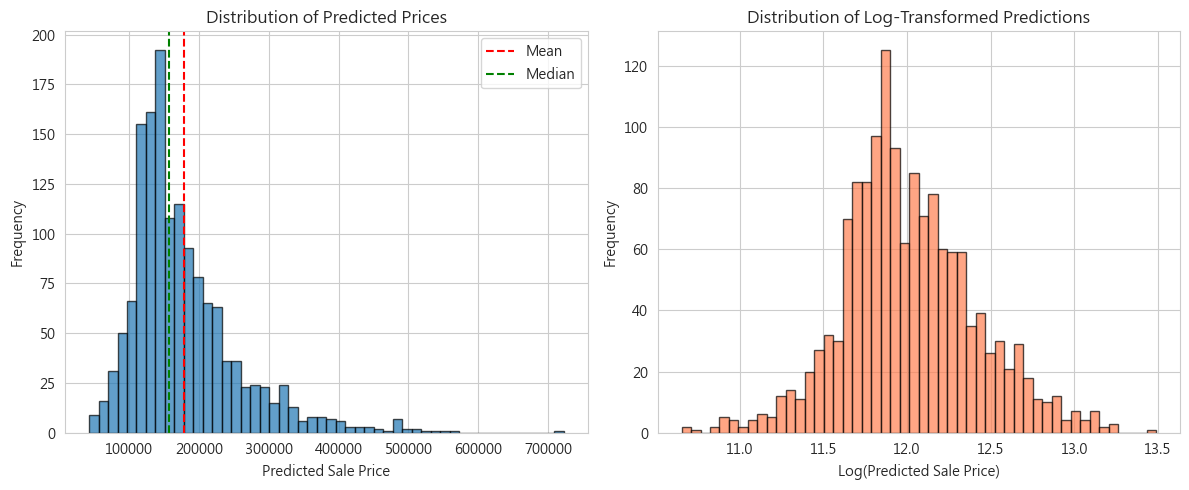

In [21]:
# 視覺化預測分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(final_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Prices')
plt.axvline(final_predictions.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(np.median(final_predictions), color='green', linestyle='--', label='Median')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(final_test_pred, bins=50, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Log(Predicted Sale Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Predictions')

plt.tight_layout()
plt.show()

## 11. 生成提交文件

In [22]:
# 創建提交文件
submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_predictions
})

# 檢查提交文件
print("提交文件預覽:")
print(submission.head(10))
print(f"\n提交文件大小: {submission.shape}")
print(f"是否有缺失值: {submission.isnull().sum().sum()}")

# 儲存提交文件
submission.to_csv('submission.csv', index=False)
print("\n✓ 提交文件已儲存: submission.csv")

提交文件預覽:
     Id      SalePrice
0  1461  122269.405003
1  1462  163375.236199
2  1463  184097.823891
3  1464  195786.400205
4  1465  189404.970849
5  1466  169909.836749
6  1467  177587.660724
7  1468  165757.165412
8  1469  180218.637504
9  1470  123997.887277

提交文件大小: (1459, 2)
是否有缺失值: 0

✓ 提交文件已儲存: submission.csv


## 12. 模型總結

In [ ]:
print("=" * 80)
print("建模總結")
print("=" * 80)

print("\n1. 模型性能 (5-Fold CV RMSE):")
print(model_results.to_string(index=False))

print(f"\n2. 最佳單一模型:")
best_model = model_results.iloc[1]  # 排除 baseline
print(f"   模型: {best_model['Model']}")
print(f"   CV RMSE: {best_model['CV_RMSE_Mean']:.6f} (+/- {best_model['CV_RMSE_Std']:.6f})")

print(f"\n3. 融合模型:")
print(f"   使用 6 個模型的加權平均")
print(f"   CV RMSE: {np.mean(ensemble_cv_scores):.6f} (+/- {np.std(ensemble_cv_scores):.6f})")

print(f"\n4. 融合模型權重:")
for name, _, _, _, weight in ensemble_models:
    print(f"   {name}: {weight}")

print(f"\n5. 預測統計:")
print(f"   最低預測價格: ${final_predictions.min():,.0f}")
print(f"   最高預測價格: ${final_predictions.max():,.0f}")
print(f"   平均預測價格: ${final_predictions.mean():,.0f}")
print(f"   中位數預測價格: ${np.median(final_predictions):,.0f}")

print("\n6. 提交文件:")
print("   檔名: submission.csv")
print(f"   樣本數: {len(submission)}")

print("\n=" * 80)
print("建模完成！可以提交到 Kaggle 了！")
print("=" * 80)

## 13. 進階優化建議

如果想進一步提升成績，可以嘗試：

### 13.1 超參數調優
```python
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# XGBoost 參數網格
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# 使用 RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     xgboost, param_grid, n_iter=50, cv=5, 
#     scoring='neg_mean_squared_error', random_state=42
# )
```

### 13.2 更多特徵工程
- 多項式特徵
- 特徵交互（如 GrLivArea × OverallQual）
- 目標編碼（Target Encoding）
- 聚類特徵

### 13.3 進階模型融合
- Stacking with meta-learner
- Blending
- 使用更多基礎模型
- 動態權重優化

### 13.4 異常值處理
- 更仔細地檢查和處理異常值
- 使用 Robust Scaler
- Winsorization

### 13.5 特徵選擇
- 使用 SHAP 值
- Recursive Feature Elimination
- Boruta 算法